# Exploratory Data Analysis (EDA) for AAPL Stock Prices

This notebook is used for performing exploratory data analysis on the historical closing prices of Apple (AAPL) stock. The goal is to visualize and understand the data before proceeding with model training.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Set visualization style
sns.set(style='whitegrid')

In [7]:
# Fetch historical data for AAPL
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the dataset
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716087,72.776613,71.466827,71.721034,135480400
2020-01-03,72.009132,72.771760,71.783977,71.941343,146322800
2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200
2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000
2020-01-08,73.403641,73.706271,71.943751,71.943751,132079200


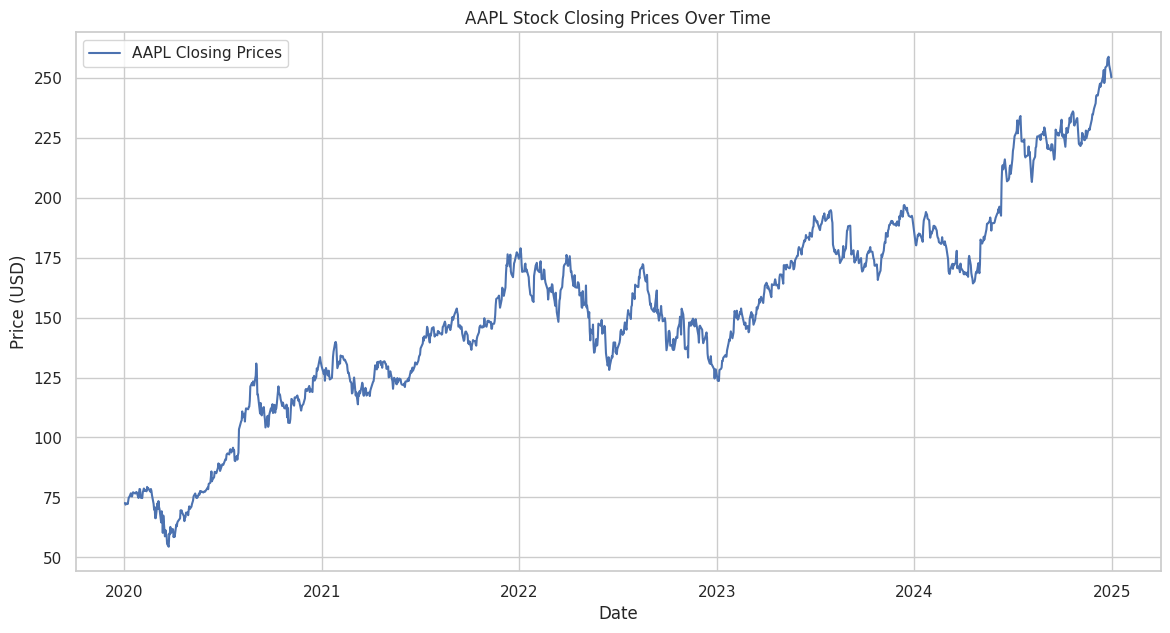

In [8]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='AAPL Closing Prices')
plt.title('AAPL Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [9]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [10]:
# Summary statistics
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,152.177631,153.707452,150.471751,152.022500,9.057384e+07
std,42.073135,42.214240,41.849262,42.016644,5.325460e+07
min,54.449894,55.452160,51.595990,55.350235,2.323470e+07
25%,126.946354,128.070209,124.935154,126.388687,5.546825e+07
50%,150.761009,152.511362,148.819366,150.580325,7.627980e+07
75%,176.831459,178.390030,175.258405,176.636626,1.077425e+08
max,258.735504,259.814335,257.347047,257.906429,4.265100e+08


## Stationarity Check and ACF/PACF Plots

ARIMA models assume that the time series is stationary (i.e., its statistical properties like mean and variance do not change over time). We can check for stationarity using statistical tests like the Augmented Dickey-Fuller (ADF) test.

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots help in determining the order (p, q) of the ARIMA model.
- **ACF**: Correlation between the series and its lags.
- **PACF**: Correlation between the series and its lags, after removing the effects of intermediate lags.

In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on Closing prices
adf_result = adfuller(data['Close'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] > 0.05:
    print('\nResult: The series is likely non-stationary (fail to reject H0)')
else:
    print('\nResult: The series is likely stationary (reject H0)')

ADF Statistic: -0.708405
p-value: 0.844560
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Result: The series is likely non-stationary (fail to reject H0)


Since the closing price series is likely non-stationary, we often apply differencing (parameter 'd' in ARIMA). Let's check the stationarity of the first difference.

In [12]:
# Calculate the first difference
data_diff = data['Close'].diff().dropna()

# Perform ADF test on the differenced series
adf_result_diff = adfuller(data_diff)

print('ADF Statistic (Differenced): %f' % adf_result_diff[0])
print('p-value (Differenced): %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result_diff[1] > 0.05:
    print('\nResult: The differenced series is likely non-stationary (fail to reject H0)')
else:
    print('\nResult: The differenced series is likely stationary (reject H0)')

ADF Statistic (Differenced): -35.938679
p-value (Differenced): 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Result: The differenced series is likely stationary (reject H0)


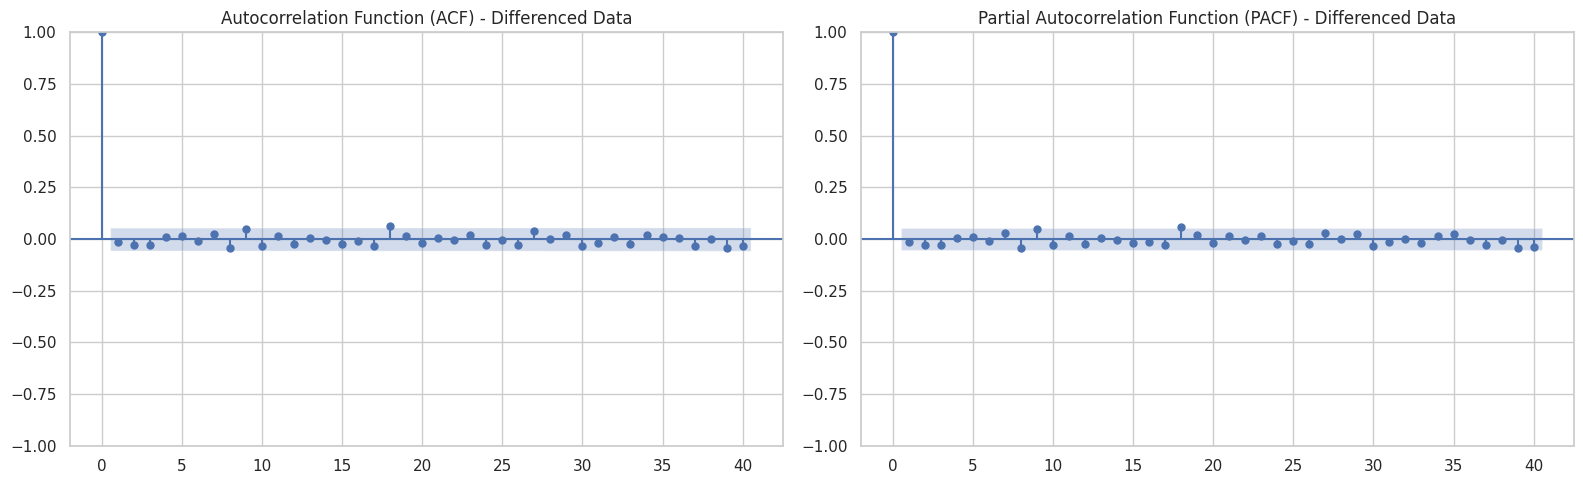

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF Plot
plot_acf(data_diff, ax=axes[0], lags=40) # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF) - Differenced Data')

# PACF Plot
plot_pacf(data_diff, ax=axes[1], lags=40) # Adjust lags as needed
axes[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Data')

plt.tight_layout()
plt.show()

**Interpretation of ACF/PACF plots (for differenced data):**
- **ACF**: Look for a sharp cutoff after lag `q` for MA(q) component.
- **PACF**: Look for a sharp cutoff after lag `p` for AR(p) component.

These plots, along with the stationarity test (suggesting d=1), help guide the selection of initial (p, d, q) values for the ARIMA model hyperparameter tuning process implemented in `scripts/train_model.py`.